In [12]:
import os
import sys
import numpy as np
import tensorflow as tf

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Import the module from the custom library
from _lib import utils
from _lib import layers
from _lib import metrics
from _lib import callbacks
from _lib import optimizers
from _lib import activations
from _lib import loss_functions
from _lib import FeedForward

### Constants and Hyperparameters

In [13]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-04 # Learning rate for the optimizer
batch_size = 32 # Number of samples to use for each batch
epochs = 200 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [14]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [15]:
def generate_sine_dataset(n_samples: int, noise: float = 0.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Method to generate a dataset of samples and targets of a sine function
    
    Parameters: 
    - n_samples (int): Number of samples to generate
    - noise float: Standard deviation of the Gaussian noise. Default is 0 (no noise)
    
    Returns:
    - tuple[np.ndarray, np.ndarray]: Features and target of the dataset
    """

    # Generate random samples
    X = np.random.uniform(-2*np.pi, 2*np.pi, (n_samples, 1)).astype(np.float32)

    # Compute the target
    y = np.sin(X) + np.random.normal(0, noise, (n_samples, 1)).astype(np.float32)
    
    # Return the dataset
    return X, y

In [16]:

# Generate the synthetic dataset of a sine function with some gaussian noise
X, y = generate_sine_dataset(n_samples, noise=data_noise)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = utils.train_test_split(X, y, test_size=train_test_split_pct, seed=seed)
X_train, X_valid, y_train, y_valid = utils.train_test_split(X_train, y_train, test_size=train_valid_split, seed=seed)

In [17]:
# Convert the dataset to tensors
X_train = tf.convert_to_tensor(X_train)
X_valid = tf.convert_to_tensor(X_valid)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_valid = tf.convert_to_tensor(y_valid)
y_test = tf.convert_to_tensor(y_test)

# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (640, 1) (640, 1)
Validation set: (160, 1) (160, 1)
Testing set: (200, 1) (200, 1)


### Data visualization

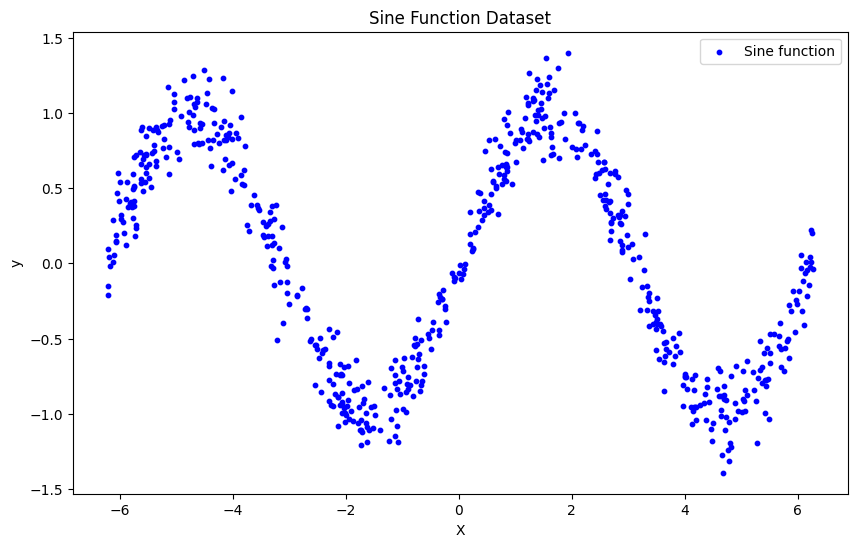

In [18]:
utils.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train, y_train))), 'label': "Sine function", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
    ],
    title = "Sine Function Dataset",
    xlabel = "X",
    ylabel = "y"
)

### Building the model

In [19]:
# Create the model
model = FeedForward([
    layers.Dense(num_units=256, activation=activations.Tanh()),
    layers.Dense(num_units=128, activation=activations.Tanh()),
    layers.Dense(num_units=32, activation=activations.Tanh()),
    layers.Dense(num_units=1)
])

# Initialize the optimizer
optimizer = optimizers.Adam(
    learning_rate = learning_rate,
    weight_decay = 0.01
)

# Initialize the error function
error_fn = loss_functions.MeanSquareError()

In [20]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
model(tf.slice(X_train, [0, 0], [batch_size, -1]));

In [21]:
# Display the model summary
model.summary()


Neural Network (ID: 1)

--------------------------------------------------------------------------------
Layer (type)                            Output Shape        Trainable params #  
dense_1 (Dense)                         (32, 256)           512                 
--------------------------------------------------------------------------------
dense_2 (Dense)                         (32, 128)           32896               
--------------------------------------------------------------------------------
dense_3 (Dense)                         (32, 32)            4128                
--------------------------------------------------------------------------------
dense_4 (Dense)                         (32, 1)             33                  
Total trainable parameters: 37569
--------------------------------------------------------------------------------


### Training the model

In [22]:
# Fit the model
history = model.fit(
    X_train = X_train, 
    y_train = y_train,
    optimizer = optimizer,
    loss_fn = error_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)

Epoch 1/200 --> loss: 0.4874 - mean absolute error: 0.5928 | Validation loss: 0.5139 - Validation mean absolute error: 0.6482
Epoch 2/200 --> loss: 0.4184 - mean absolute error: 0.5416 | Validation loss: 0.4337 - Validation mean absolute error: 0.5910
Epoch 3/200 --> loss: 0.3514 - mean absolute error: 0.4930 | Validation loss: 0.3787 - Validation mean absolute error: 0.5474
Epoch 4/200 --> loss: 0.2855 - mean absolute error: 0.4299 | Validation loss: 0.2917 - Validation mean absolute error: 0.4795
Epoch 5/200 --> loss: 0.2231 - mean absolute error: 0.3735 | Validation loss: 0.2329 - Validation mean absolute error: 0.4197
Epoch 6/200 --> loss: 0.1744 - mean absolute error: 0.3268 | Validation loss: 0.1645 - Validation mean absolute error: 0.3533
Epoch 7/200 --> loss: 0.1427 - mean absolute error: 0.2961 | Validation loss: 0.1356 - Validation mean absolute error: 0.3092
Epoch 8/200 --> loss: 0.1286 - mean absolute error: 0.2827 | Validation loss: 0.1204 - Validation mean absolute error:

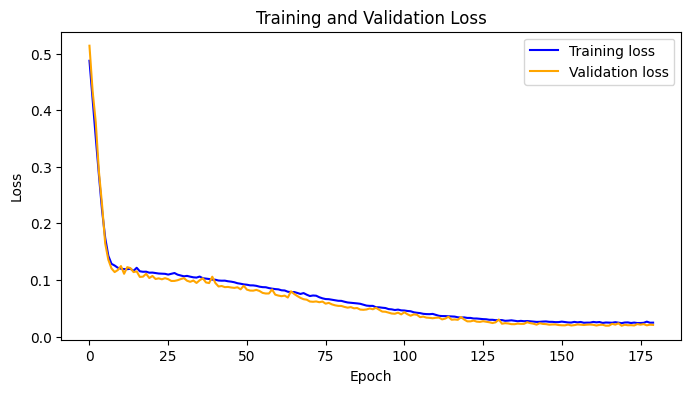

In [23]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Evaluation

In [24]:
# Predict the labels
predictions = model(X_test)

In [25]:
# Calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, predictions)

# Print the mean absolute error
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.12971873581409454


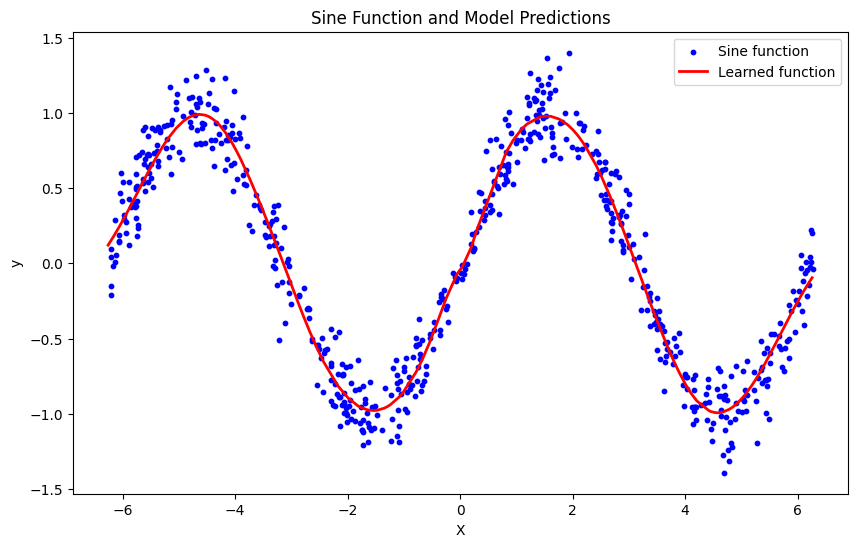

In [26]:
# Plot the sine function and the model predictions
utils.plot_data(
    datasets = [
        {'points': np.array(list(zip(X_train, y_train))), 'label': "Sine function", 'color': "blue", 'size': 10, 'plot_type': 'scatter'},
        {'points': np.array(list(zip(X_test, predictions))), 'label': "Learned function", 'color': "red", 'plot_type': 'line'}
    ],
    title = "Sine Function and Model Predictions",
    xlabel = "X",
    ylabel = "y"
)